# What is POS Tagging?

Part of Speech (POS) Tagging is a classification task that involves automatically assigning descriptions to tokens. The descriptor, called a tag, represents the part-of-speech of the word it is assigned to.

In this tutorial, you will learn how to build your own POS tagger. We will be implementing a bi-directional LSTM (BiLSTM) to predict POS tags. We will use the Universal Dependencies English Web Treebank (UDPOS) dataset. You can check more information for UDPOS here: https://pytorch.org/text/stable/_modules/torchtext/datasets/udpos.html

## What you will need 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy import data
from torchtext.legacy import datasets

import spacy
import numpy as np

import time
import random

Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

However, there are some steps you can take to limit the number of sources of nondeterministic behavior for a specific platform, device, and PyTorch release. First, you can control sources of randomness that can cause multiple executions of your application to behave differently. Second, you can configure PyTorch to avoid using nondeterministic algorithms for some operations, so that multiple calls to those operations, given the same inputs, will produce the same result.

We will use torch.manual_seed() to seed the RNG for all devices (both CPU and CUDA) and python's random seed. We will also use a deterministic implementation:

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TorchText Field how your dataset is processed. The TEXT field handles how the text that we need to tag is processed. We set lower = True to lowercase all of the text.

Next we will define the Fields for the tags. UDPOS dataset has two different sets of tags namely: the universal dependency (UD) tags and Penn Treebank (PTB) tags. We will train our model with the PTB tags.

TorchText Fields initialize a default unknown token <unk> which we remove by setting unk_token = None. We set unk_token = None because we do not want unk_token tags in our tag set when the model encounters words without tags. We want every word tagged only with the tags in the PTB tags.
    
You can find more information about field her: https://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Field

In [18]:
TEXT = data.Field(lower = True)
UD_TAGS = data.Field(unk_token = None)
PTB_TAGS = data.Field(unk_token = None)

We define fields for both the UD_TAGS and PTB_TAGS which passes the fields to the dataset. To define one of the tags alone, we can tell torchtext not to load those items using "NONE" as in

fields = (("text", TEXT), ("udtags", UD_TAGS), (None, None))

In [19]:
fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

We will then use the fields

In [20]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

We check the size of our train, valid and test sets. 

In [64]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


We can also print different examples and specify the text or the tags

In [63]:
print(vars(train_data.examples[0]))

{'text': ['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.'], 'udtags': ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], 'ptbtags': ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']}


In [24]:
print(vars(train_data.examples[0])['text'])

['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']


In [25]:
print(vars(train_data.examples[0])['udtags'])

['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


In [26]:
print(vars(train_data.examples[0])['ptbtags'])

['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']


You should now construct your vocabulary from the training data by calling the build_vocab function for the approporiate fields. The vocabulary maps tokens to integers. We want some unknown tokens within our dataset in order to replicate how this model would be used in real life, so we set the min_freq to 2 which means only tokens that appear at least twice in the training set will be added to the vocabulary and the rest will be replaced by <unk> tokens.

We also load the fast-text pre-trained token embeddings. Other pre-trained embeddings can be used and you can find examples here: https://pytorch.org/text/stable/_modules/torchtext/vocab.html
    
unk_init is used to initialize the token embeddings which are not in the pre-trained embedding vocabulary. By default this sets those embeddings to zeros, however it is better to not have them all initialized to the same value, so we initialize them from a Normal/Gaussian distribution.

These pre-trained vectors are now loaded into our vocabulary and we will initialize our model with these values later.

In [65]:
MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "fasttext.simple.300d",
                 unk_init = torch.Tensor.normal_)


UD_TAGS.build_vocab(train_data)
PTB_TAGS.build_vocab(train_data)

.vector_cache\wiki.simple.vec: 293MB [00:08, 36.6MB/s]                                                                                    
100%|██████████████████████████████████████████████████████████████████████████████████████████| 111051/111051 [00:10<00:00, 10467.09it/s]


We can check how many tokens and tags are in our vocabulary by getting their length:

In [29]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in UD_TAG vocabulary: {len(UD_TAGS.vocab)}")
print(f"Unique tokens in PTB_TAG vocabulary: {len(PTB_TAGS.vocab)}")

Unique tokens in TEXT vocabulary: 8866
Unique tokens in UD_TAG vocabulary: 18
Unique tokens in PTB_TAG vocabulary: 51


We can check the 10 most common tokens within our texts:

In [30]:
print(TEXT.vocab.freqs.most_common(10))

[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('is', 2239)]


We can check the tags in our vocabularies:

In [31]:
print(UD_TAGS.vocab.itos)

['<pad>', 'NOUN', 'PUNCT', 'VERB', 'PRON', 'ADP', 'DET', 'PROPN', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PART', 'NUM', 'SCONJ', 'X', 'INTJ', 'SYM']


In [32]:
print(PTB_TAGS.vocab.itos)

['<pad>', 'NN', 'IN', 'DT', 'NNP', 'PRP', 'JJ', 'RB', '.', 'VB', 'NNS', ',', 'CC', 'VBD', 'VBP', 'VBZ', 'CD', 'VBN', 'VBG', 'MD', 'TO', 'PRP$', '-RRB-', '-LRB-', 'WDT', 'WRB', ':', '``', "''", 'WP', 'RP', 'UH', 'POS', 'HYPH', 'JJR', 'NNPS', 'JJS', 'EX', 'NFP', 'GW', 'ADD', 'RBR', '$', 'PDT', 'RBS', 'SYM', 'LS', 'FW', 'AFX', 'WP$', 'XX']


The UD_TAGS and the PTB_TAGS are different. We can check which tags are most common in our vocabulary. 

To check the frequencies of all tags in our vocabulary, we do not specify any number. 

In [33]:
print(UD_TAGS.vocab.freqs.most_common())

[('NOUN', 34781), ('PUNCT', 23679), ('VERB', 23081), ('PRON', 18577), ('ADP', 17638), ('DET', 16285), ('PROPN', 12946), ('ADJ', 12477), ('AUX', 12343), ('ADV', 10548), ('CCONJ', 6707), ('PART', 5567), ('NUM', 3999), ('SCONJ', 3843), ('X', 847), ('INTJ', 688), ('SYM', 599)]


In [34]:
print(PTB_TAGS.vocab.freqs.most_common())

[('NN', 26915), ('IN', 20724), ('DT', 16817), ('NNP', 12449), ('PRP', 12193), ('JJ', 11591), ('RB', 10831), ('.', 10317), ('VB', 9476), ('NNS', 8438), (',', 8062), ('CC', 6706), ('VBD', 5402), ('VBP', 5374), ('VBZ', 4578), ('CD', 3998), ('VBN', 3967), ('VBG', 3330), ('MD', 3294), ('TO', 3286), ('PRP$', 3068), ('-RRB-', 1008), ('-LRB-', 973), ('WDT', 948), ('WRB', 869), (':', 866), ('``', 813), ("''", 785), ('WP', 760), ('RP', 755), ('UH', 689), ('POS', 684), ('HYPH', 664), ('JJR', 503), ('NNPS', 498), ('JJS', 383), ('EX', 359), ('NFP', 338), ('GW', 294), ('ADD', 292), ('RBR', 276), ('$', 258), ('PDT', 175), ('RBS', 169), ('SYM', 156), ('LS', 117), ('FW', 93), ('AFX', 48), ('WP$', 15), ('XX', 1)]


Finally we create iterators. The iterators takes the vocabulary in batches we define. We used a bucket iterator. Details are here: https://torchtext.readthedocs.io/en/latest/data.html#iterator 

The bucket iterator https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator defines an iterator that batches examples of similar lengths together which minimizes the amount of padding needed while producing freshly shuffled batches for each new epoch.

In [35]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

We define a multi-layer bi-directional LSTM. The image below shows a simplified version of the model with only one LSTM layer and omitting the LSTM's cell state for clarity.

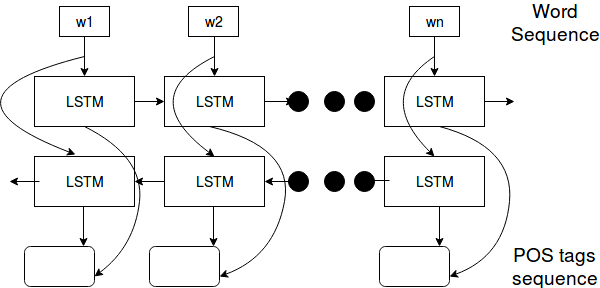

The model takes in a sequence of tokens,  in this case w1 ... wn which are represented as embeddings and passes them to the forward and backward LSTMs. The forward LSTM processes the sequence from left-to-right, whilst the backward LSTM processes the sequence right-to-left, i.e. the first input to the forward LSTM is  w1  and the first input to the backward LSTM is  wn.

After the whole sequence has been processed, the hidden and cell states are then passed to the next layer of the LSTM in a multidimensional LSTM as we will use.

When training the model, we will compare our predicted tags,  Y^  against the actual tags,  Y , to calculate a loss, the gradients w.r.t. that loss, and then update our parameters.

We implement the BILSTM model above in the BiLSTMPOSTagger class.

nn.Embedding is an embedding layer and the input dimension should be the size of the input (text) vocabulary. We tell it what the index of the padding token is so it does not update the padding token's embedding entry.

nn.LSTM is the LSTM. We apply dropout as regularization between the layers, if we are using more than one.

nn.Linear defines the linear layer to make predictions using the LSTM outputs. We double the size of the input if we are using a bi-directional LSTM. The output dimensions should be the size of the tag vocabulary.

We also define a dropout layer with nn.Dropout, which we use in the forward method to apply dropout to the embeddings and the outputs of the final layer of the LSTM.

In [36]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        #pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
        
        #we use our outputs to make a prediction of what the tag should be
        predictions = self.fc(self.dropout(outputs))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

## Training the Model

We instantiate the BiLSTMPOSTagger model. We need to ensure the embedding dimensions is the same size as that of the embeddings we loaded. 

The other values are hyperparameters and different combinations of values can improve or worsen the models. They therefore need to be chosen carefully. The input and output dimensions are taken directly from the lengths of the respective vocabularies. The padding index is obtained using the vocabulary and the Field of the text.

In [72]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = len(PTB_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

We initialize the weights from a simple Normal distribution. This is also a hyperparameter and different values may be better for this model and dataset.

In [73]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMPOSTagger(
  (embedding): Embedding(8866, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

We will initialize our model's embedding layer with the pre-trained embedding values we loaded earlier.

This is done by getting them from the vocab's vectors attribute and then performing a copy to overwrite the embedding layer's current weights.

We also initialize the embedding of the pad token to all zeros. This, along with setting the padding_idx in the model's embedding layer, means that the embedding should always output a tensor full of zeros when a pad token is input.

In [74]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([8866, 300])


In [75]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.2213, -0.2354, -0.4294,  ..., -1.4476, -0.4606, -0.7150],
        [-0.8855,  1.6317, -0.2035,  ...,  2.3360, -1.5412,  2.7414],
        [ 0.0104, -0.1829,  0.0761,  ..., -0.1362, -0.2240, -0.0552],
        ...,
        [-1.9967,  1.1004,  1.1619,  ...,  0.9477, -0.4274, -2.3395],
        [-0.1719, -0.1336, -0.1457,  ...,  0.2113, -0.1002, -0.0555],
        [-0.3669,  0.1386,  0.5516,  ..., -0.7994, -0.5704, -0.3140]])

In [76]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[-0.2213, -0.2354, -0.4294,  ..., -1.4476, -0.4606, -0.7150],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0104, -0.1829,  0.0761,  ..., -0.1362, -0.2240, -0.0552],
        ...,
        [-1.9967,  1.1004,  1.1619,  ...,  0.9477, -0.4274, -2.3395],
        [-0.1719, -0.1336, -0.1457,  ...,  0.2113, -0.1002, -0.0555],
        [-0.3669,  0.1386,  0.5516,  ..., -0.7994, -0.5704, -0.3140]])


We then define our optimizer, used to update our parameters w.r.t. their gradients. We use Adam with the default learning rate.

In [78]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function, cross-entropy loss.

Even though we have no <unk> tokens within our tag vocab, we still have <pad> tokens. This is because all sentences within a batch need to be the same size. However, we don't want to calculate the loss when the target is a <pad> token as we aren't training our model to recognize padding tokens.

We handle this by setting the ignore_index in our loss function to the index of the padding token in our tag vocabulary.
    
We then place our model and loss function on our GPU, if we have one.

In [79]:
TAG_PAD_IDX = PTB_TAGS.vocab.stoi[PTB_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [80]:
model = model.to(device)
criterion = criterion.to(device)

We will be using the loss value between our predicted and actual tags to train the network, but ideally we'd like a more interpretable way to see how well our model is doing - accuracy.

The issue is that we don't want to calculate accuracy over the <pad> tokens as we aren't interested in predicting them.

The function below only calculates accuracy over non-padded tokens. Non_pad_elements is a tensor containing the indices of the non-pad tokens within an input batch. We then compare the predictions of those elements with the labels to get a count of how many predictions were correct. We then divide this by the number of non-pad elements to get our accuracy value over the batch.

In [81]:
def accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

We first set the model to train mode to turn on dropout/batch-norm/etc. (if used). Then we iterate over our iterator, which returns a batch of examples.

For each batch:

we zero the gradients over the parameters from the last gradient calculation
insert the batch of text into the model to get predictions
as PyTorch loss functions cannot handle 3-dimensional predictions we reshape our predictions
calculate the loss and accuracy between the predicted tags and actual tags
call backward to calculate the gradients of the parameters w.r.t. the loss
take an optimizer step to update the parameters
add to the running total of loss and accuracy

In [82]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.udtags
        
        optimizer.zero_grad()
        
        #text = [sent len, batch size]
        
        predictions = model(text)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In the evaluate function, we don't update the model's parameters because we are only interested in comparing the actual tags with the predicted tags. We place the model in evaluation mode using model.eval().

In [83]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.udtags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Finally, we train our model!

After each epoch we check if our model has achieved the best validation loss so far. If it has then we save the parameters of this model and we will use these "best" parameters to calculate performance over our test set.

In [84]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

	Train Loss: 1.248 | Train Acc: 61.59%
	 Val. Loss: 0.530 |  Val. Acc: 83.89%
	Train Loss: 0.326 | Train Acc: 89.84%
	 Val. Loss: 0.413 |  Val. Acc: 88.20%
	Train Loss: 0.243 | Train Acc: 92.29%
	 Val. Loss: 0.385 |  Val. Acc: 88.90%
	Train Loss: 0.203 | Train Acc: 93.47%
	 Val. Loss: 0.375 |  Val. Acc: 89.33%
	Train Loss: 0.176 | Train Acc: 94.29%
	 Val. Loss: 0.364 |  Val. Acc: 89.72%
	Train Loss: 0.156 | Train Acc: 94.91%
	 Val. Loss: 0.358 |  Val. Acc: 90.07%
	Train Loss: 0.139 | Train Acc: 95.49%
	 Val. Loss: 0.354 |  Val. Acc: 90.03%
	Train Loss: 0.126 | Train Acc: 95.89%
	 Val. Loss: 0.372 |  Val. Acc: 90.06%
	Train Loss: 0.114 | Train Acc: 96.31%
	 Val. Loss: 0.372 |  Val. Acc: 90.18%
	Train Loss: 0.103 | Train Acc: 96.63%
	 Val. Loss: 0.371 |  Val. Acc: 90.22%


We then load our "best" parameters and evaluate performance on the test set.

In [85]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.369 |  Test Acc: 89.34%
